# Unsupervised Learning - Matrix Completion

In this exercise we will:

- create some synthetic data in the form of a matrix
- delete a portion of the data
- use various matrix completion algorithms to fill the incomplete matrix
- compare the matrix completion algorithms

To get started, we will be using the [fancyimpute](https://github.com/iskandr/fancyimpute) library.

To install libraries in Python we use [`pip`](https://pip.pypa.io/en/stable/) to install globally or [`pipenv`](https://github.com/pypa/pipenv) to install locally. Depending on if you are working on this on your computer or on colab, you will want to uncomment a different line in the next cell. As colab is our own server environment, you can install things globally, whereas on your computer you want to install dependencies on a per project basis and so should use `pipenv` instead.

In Jupyter notebooks, we can run a command in shell by starting the cell with `!`.

In [0]:
#!pip install fancyimpute
#!pipenv install fancyimpute

/bin/sh: pipenv: command not found


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from fancyimpute import SimpleFill, KNN, MatrixFactorization

%matplotlib inline
plt.style.use("ggplot")

np.random.seed(0)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


## Synthetic Data
First, let us create some synthetic data that we are going to use to test out a variety of matrix completion algorithms. Note that we force the data in $X$ to have a rank equal to five. 

In [0]:
# Create the data matrix X
n = 30
m = 30
inner_rank = 5
X = np.dot(np.random.randn(n, inner_rank), np.random.randn(inner_rank, m))

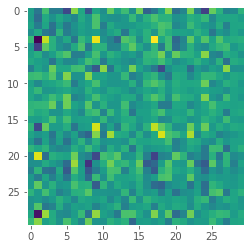

In [3]:
# Let's visualize the matrix X
plt.figure()
plt.imshow(X)
plt.grid(False)
plt.show()

## Removing Data From $X$
Since we are studying matrix completion algorithms we need to have some missing values! To do this we will randomly remove some data from $X$. 

Remember... since $X$ can be represented by `inner_rank = 5` linearly independent columns it should be relatively easy for a matrix completion algorithm to reconstruct the missing data.

In [0]:
# Since our values are random from 0 to 1 we can select a cutoff to remove all points less than a value
# Doing so is a good enough approximation of removing that percentage of the matrix
# You may change the cutoff value and see how your results change
cutoff = 0.4
missing_mask = np.random.rand(*X.shape) < cutoff
X_incomplete = X.copy()
# missing entries indicated with NaN
X_incomplete[missing_mask] = np.nan

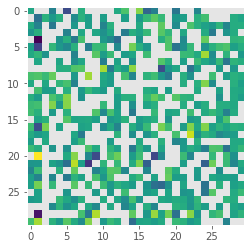

In [5]:
# Let's visualize the data matrix X_incomplete
plt.figure()
plt.imshow(X_incomplete)
plt.grid(False)
plt.show()

## Matrix Completion
Now, given the incomplete matrix `X_incomplete` we want to try and fill in the missing values. For this we are going to use the https://github.com/iskandr/fancyimpute package in Python.

For the first example, I will provide an example implementation where we fill in all the missing values using `SimpleFill`. SimpleFill will complete the matrix using an average metric.

In [0]:
meanFill = SimpleFill("mean")
X_filled_mean = meanFill.fit_transform(X_incomplete)

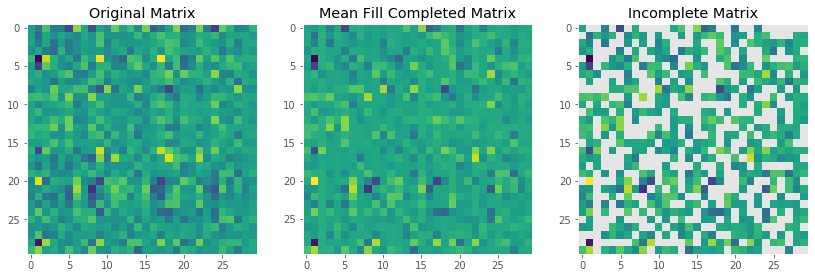

In [11]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,6))

ax1.imshow(X)
ax1.set_title("Original Matrix"
ax1.grid(False)

ax2.imshow(X_filled_mean)
ax2.set_title("Mean Fill Completed Matrix")
ax2.grid(False)

ax3.imshow(X_incomplete)
ax3.set_title("Incomplete Matrix")
ax3.grid(False)
plt.show()

In [0]:
# To test the performance of our matrix completion algorithm we want to compare
# the "filled-in" values to the original:
def mat_completion_mse(X_filled, X_truth, missing_mask):
    """Calculates the mean squared error of the filled in values vs. the truth
    
    Args:
        X_filled (np.ndarray): The "filled-in" matrix from a matrix completion algorithm
        X_truth (np.ndarray): The true filled in matrix
        missing_mask (np.ndarray): Boolean array of missing values
    
    Returns:
        float: Mean squares error of the filled values
    """
    mse = ((X_filled[missing_mask] - X[missing_mask]) ** 2).mean()
    return mse

In [10]:
meanFill_mse = mat_completion_mse(X_filled_mean, X, missing_mask)
print("meanFill MSE: %f" % meanFill_mse)

meanFill MSE: 5.241120


### KNN Completion

Next you will use the K-Nearest Neighbors algorithm to fill in the missing values. First, we will need to find the best number of neighbors to use for the KNN algorithm. Write the below function that uses fancyimpute's KNN method to fill the matrix with various values of $k$ and returns the best value.  

In [0]:
# Find the best value for k
def find_best_k(k_neighbors, complete_mat, incomplete_mat, missing_mask):
    """Determines the best k to use for matrix completion with KNN
    
    Args:
        k_neighbors (iterable): The list of k's to try
        complete_mat (np.ndarray): The original matrix with complete values
        incomplete_mat (np.ndarray): The matrix with missing values
        missing_mask (np.ndarray): Boolean array of missing values
    
    Returns:
        integer: the best value of k to use for that particular matrix
    """
    best_k = -1
    best_k_mse = np.infty
    
    for neighbors in k_neighbors:
        # YOUR CODE HERE
        X_filled = KNN(k=neighbors).fit_transform(incomplete_mat)
        knn_mse = mat_completion_mse(X_filled, complete_mat, missing_mask)
        if knn_mse < best_k_mse:
          best_k_mse = knn_mse
          best_k = neighbors 
    return best_k

In [13]:
k_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
best_k = find_best_k(k_neighbors, X, X_incomplete, missing_mask)

Imputing row 1/30 with 19 missing, elapsed time: 0.002
Imputing row 1/30 with 19 missing, elapsed time: 0.002
Imputing row 1/30 with 19 missing, elapsed time: 0.001
Imputing row 1/30 with 19 missing, elapsed time: 0.001
Imputing row 1/30 with 19 missing, elapsed time: 0.001
Imputing row 1/30 with 19 missing, elapsed time: 0.001
Imputing row 1/30 with 19 missing, elapsed time: 0.001
Imputing row 1/30 with 19 missing, elapsed time: 0.001
Imputing row 1/30 with 19 missing, elapsed time: 0.001
Imputing row 1/30 with 19 missing, elapsed time: 0.001


In [0]:
assert best_k == 3

Now that we have found the `best_k` to use let's see how well it performed:

In [15]:
# Run KNN with the best_k and store the resulting filled matrix in X_filled_knn

# YOUR CODE HERE
X_filled_knn = KNN(k = 3).fit_transform(X_incomplete)
knnFill_mse = mat_completion_mse(X_filled_knn, X, missing_mask)
print("knnFill MSE: %f" % knnFill_mse)

Imputing row 1/30 with 19 missing, elapsed time: 0.003
knnFill MSE: 2.977082


In [0]:
assert knnFill_mse < meanFill_mse

In [0]:
# This is an implementation of a matrix completion algorithm using alternating minimization.
# It is derived from the handout supplied in today's class.

class AlternatingMinimization:
    def __init__(self,rank):
        self.rank = rank
        
    def fit_transform(self, X_incomplete):
        """
        Fit and transform an incomplete matrix, returning the completed matrix.
        """
        P = np.random.random_sample((n, self.rank))
        Q = np.random.random_sample((self.rank, m))
        # Fill in all missing values with zeros
        X_incomplete_to_zero = np.nan_to_num(X_incomplete)

        for i in range(0, 100):
            P = X_incomplete_to_zero @ Q.T @ np.linalg.pinv(Q @ Q.T)
            Q = np.linalg.pinv(P.T @ P) @ P.T @ X_incomplete_to_zero

        X_filled = P @ Q
        
        return X_filled

## Visual Comparison of Matrix Completion Algorithms

To get a good idea of how these matrix completion algorithms compare we want to create a method that visualizes how well these algorithms actually perform.

#### Creating a Collection of Models
Now we create a handful of matrix completion algorithms that we want to visualize:
 - Mean Fill
 - K-Nearest Neighbors
 - Alternating Minimization (derived in class)
 - MatrixFactorization (an implementaiton using gradient descent)

In [0]:
simpleFill = SimpleFill("mean")
knnFill = KNN(k=best_k)
amFill = AlternatingMinimization(rank=5)
mfFill = MatrixFactorization(learning_rate=0.01, rank=5, l2_penalty=0, min_improvement=1e-6)
methods = [simpleFill, knnFill, amFill, mfFill]
names = ["SimpleFill", "KNN", "AltMin", "MatFactor"]

In [0]:
def mat_completion_comparison(methods, incomplete_mat, complete_mat, missing_mask):
    """Using a list of provided matrix completion methods calculate 
    the completed matrix and the determine the associated 
    mean-squared-error results.
    
    Args:
        methods (iterable): A list of matrix completion algorithms
        incomplete_mat (np.ndarray): The incomplete matrix
        complete_mat (np.ndarray): The full matrix
        missing_mask (np.ndarray): Boolean array of missing values
    
    Returns:
        filled_mats (iterable): the "filled-in" matrices
        mses (iterable): the mean square error results
    """
    X_filled_mats = []
    mses = []
    for method in methods:
        # YOUR CODE HERE
        X_filled_mats.append(method.fit_transform(incomplete_mat))
        mses.append(mat_completion_mse(X_filled_knn, X, missing_mask))
    return X_filled_mats, mses

In [23]:
X_filled_mats, mses = mat_completion_comparison(methods, X_incomplete, X, missing_mask)
assert len(X_filled_mats) == len(methods)
assert len(mses) == len(methods)

Imputing row 1/30 with 19 missing, elapsed time: 0.002







Train on 471 samples, validate on 53 samples
Epoch 1/10000





471/471 [==============================] - 1s 2ms/step - loss: 1.1338 - val_loss: 1.5158
Epoch 2/10000
471/471 [==============================] - 0s 14us/step - loss: 1.0922 - val_loss: 1.5216
Epoch 3/10000
471/471 [==============================] - 0s 19us/step - loss: 1.0680 - val_loss: 1.5270
Epoch 4/10000
471/471 [==============================] - 0s 12us/step - loss: 1.0478 - val_loss: 1.5320
Epoch 5/10000
471/471 [==============================] - 0s 11us/step - loss: 1.0292 - val_loss: 1.5367
Epoch 6/10000
471/471 [==============================] - 0s 8us/step - loss: 1.0113 - val_loss: 1.5411


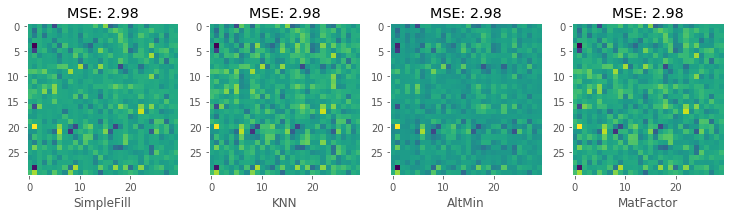

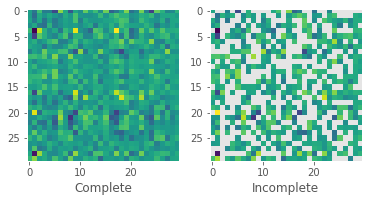

In [24]:
plt.figure(figsize = (19,6)) # Change the figure size to your liking

for i in range(0, len(methods)):
    X_filled = X_filled_mats[i]
    mse = mses[i]
    ax = plt.subplot(161 + i)
    ax.imshow(X_filled)
    ax.title.set_text("MSE: " + str(round(mse, 2)))
    ax.set_xlabel(names[i])
    ax.grid(False)
plt.show()

ax = plt.subplot(121)
ax.imshow(X)
ax.set_xlabel("Complete")
ax.grid(False)

ax = plt.subplot(122)
ax.imshow(X_incomplete)
ax.set_xlabel("Incomplete")
ax.grid(False)
    
plt.show()

## Feedback

In [0]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    # YOUR CODE HERE
    return "This was a good exercise in matrix completion."

In [26]:
feedback()

'This was a good exercise in matrix completion.'